##INSTALLATIONS

In [ ]:
!python -m venv myenv
!myenv/Scripts/activate

!pip install xgboost
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install streamlit

##IMPORTING LIBRARIES

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import iqr

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

import pickle

##DATA COLLECTION

In [ ]:
from google.colab import files
files.upload()  # Select the file from your computer

In [10]:
df = pd.read_csv('gcd.csv', index_col=0)

##DATA INSPECTION

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


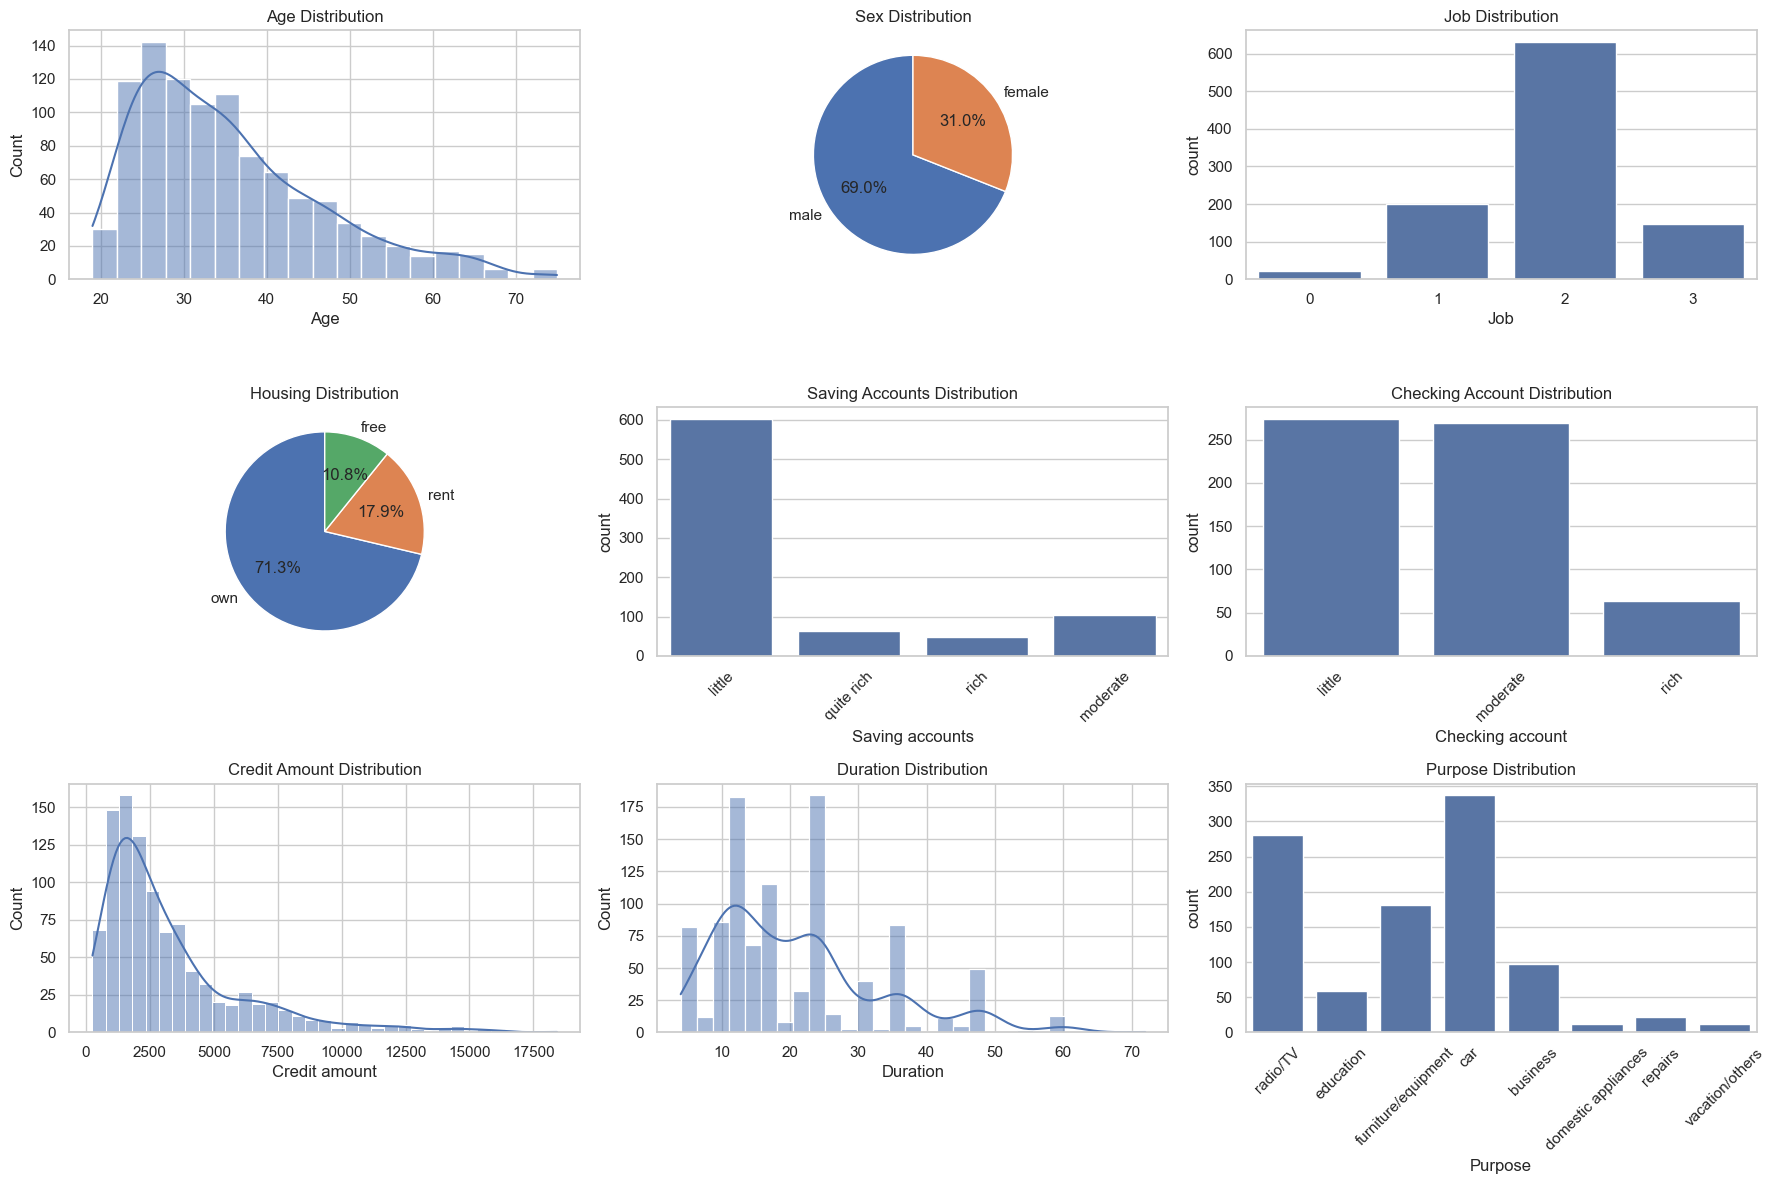

In [12]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. Age
sns.histplot(df['Age'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Age Distribution")

# 2. Sex
sex_counts = df['Sex'].value_counts()  # Get counts for 'Sex' categories
axes[0, 1].pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Sex Distribution")

# 3. Job
sns.countplot(x='Job', data=df, ax=axes[0, 2])
axes[0, 2].set_title("Job Distribution")

# 4. Housing
housing_counts = df['Housing'].value_counts()  # Get counts for 'Housing' categories
axes[1, 0].pie(housing_counts, labels=housing_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("Housing Distribution")

# 5. Saving Accounts
sns.countplot(x='Saving accounts', data=df, ax=axes[1, 1])
axes[1, 1].set_title("Saving Accounts Distribution")
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Checking Account
sns.countplot(x='Checking account', data=df, ax=axes[1, 2])
axes[1, 2].set_title("Checking Account Distribution")
axes[1, 2].tick_params(axis='x', rotation=45)

# 7. Credit Amount
sns.histplot(df['Credit amount'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title("Credit Amount Distribution")

# 8. Duration
sns.histplot(df['Duration'], kde=True, ax=axes[2, 1])
axes[2, 1].set_title("Duration Distribution")

# 9. Purpose
sns.countplot(x='Purpose', data=df, ax=axes[2, 2])
axes[2, 2].set_title("Purpose Distribution")
axes[2, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()

In [13]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


##DATA CLEANING

In [14]:
for col in df.columns.tolist():
  print (col," : ", df[col].unique())

Age  :  [67 22 49 45 53 35 61 28 25 24 60 32 44 31 48 26 36 39 42 34 63 27 30 57
 33 37 58 23 29 52 50 46 51 41 40 66 47 56 54 20 21 38 70 65 74 68 43 55
 64 75 19 62 59]
Sex  :  ['male' 'female']
Job  :  [2 1 3 0]
Housing  :  ['own' 'free' 'rent']
Saving accounts  :  [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account  :  ['little' 'moderate' nan 'rich']
Credit amount  :  [ 1169  5951  2096  7882  4870  9055  2835  6948  3059  5234  1295  4308
  1567  1199  1403  1282  2424  8072 12579  3430  2134  2647  2241  1804
  2069  1374   426   409  2415  6836  1913  4020  5866  1264  1474  4746
  6110  2100  1225   458  2333  1158  6204  6187  6143  1393  2299  1352
  7228  2073  5965  1262  3378  2225   783  6468  9566  1961  6229  1391
  1537  1953 14421  3181  5190  2171  1007  1819  2394  8133   730  1164
  5954  1977  1526  3965  4771  9436  3832  5943  1213  1568  1755  2315
  1412 12612  2249  1108   618  1409   797  3617  1318 15945  2012  2622
  2337  7057  1469  2323   93

In [15]:
df.columns.tolist()

['Age',
 'Sex',
 'Job',
 'Housing',
 'Saving accounts',
 'Checking account',
 'Credit amount',
 'Duration',
 'Purpose']

##OUTLIER REMOVAL

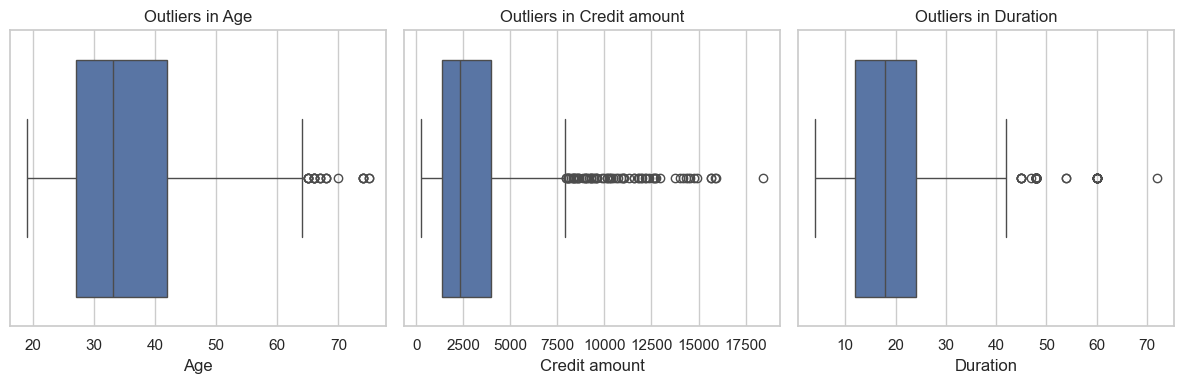

In [16]:
# List of numerical columns in your dataframe
numerical_cols = ['Age', 'Credit amount', 'Duration']

# Create a box plot for each numerical column to visualize outliers
plt.figure(figsize=(12, 4))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, len(numerical_cols), i)
    sns.boxplot(x=df[col])
    plt.title(f'Outliers in {col}')

plt.tight_layout()
plt.show()

In [17]:
# List of numerical columns
numerical_cols = ['Age', 'Credit amount', 'Duration']

for col in numerical_cols:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = iqr(df[col])
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"Outliers in '{col}': {outliers[col].tolist()}\n")

Outliers in 'Age': [67, 66, 66, 70, 65, 74, 68, 66, 75, 74, 65, 75, 67, 74, 65, 66, 74, 66, 67, 65, 68, 65, 68]

Outliers in 'Credit amount': [9055, 8072, 12579, 9566, 14421, 8133, 9436, 12612, 15945, 11938, 8487, 10144, 8613, 9572, 10623, 10961, 14555, 8978, 12169, 11998, 10722, 9398, 9960, 10127, 11590, 13756, 14782, 14318, 12976, 11760, 8648, 8471, 11328, 11054, 8318, 9034, 8588, 7966, 8858, 12389, 12204, 9157, 15653, 7980, 8086, 10222, 10366, 9857, 14027, 11560, 14179, 12680, 8065, 9271, 9283, 9629, 15857, 8335, 11816, 10875, 9277, 15672, 8947, 10477, 18424, 14896, 12749, 10297, 8358, 10974, 8386, 8229]

Outliers in 'Duration': [48, 48, 60, 45, 48, 48, 48, 54, 54, 48, 48, 60, 48, 48, 45, 48, 48, 60, 48, 48, 47, 48, 48, 48, 48, 48, 48, 60, 48, 60, 60, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 60, 48, 60, 48, 48, 48, 60, 72, 60, 48, 48, 60, 48, 48, 48, 48, 48, 48, 45, 48, 48, 48, 48, 60, 48, 60, 48, 45, 45]



In [18]:
# ASSUMING CREDIT AMOUNT AND DURATION OUTLIERS ARE ACTUALLY VALID WE ARE ONLY REMOVING AGE OUTLIERS
# Drop outliers only for the 'Age' column
Q1, Q3 = df['Age'].quantile(0.25), df['Age'].quantile(0.75)
IQR = iqr(df['Age'])
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df_cleaned = df[(df['Age'] >= lower) & (df['Age'] <= upper)]
print ('Dropped ',df.shape[0]-df_cleaned.shape[0],' data points out of ',df.shape[0], ' : AGE OUTLIERS')

Dropped  23  data points out of  1000  : AGE OUTLIERS


In [19]:
df=df_cleaned

##MISSING VALUES

In [20]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     179
Checking account    389
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [21]:
mode_value = df['Saving accounts'].mode()[0]
df['Saving accounts'].fillna(mode_value, inplace=True)
mode_value_checking = df['Checking account'].mode()[0]  # 'little'
df['Checking account'].fillna(mode_value_checking, inplace=True)

In [22]:
df.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

##FEATURE ENGINEERING

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 977 entries, 1 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               977 non-null    int64 
 1   Sex               977 non-null    object
 2   Job               977 non-null    int64 
 3   Housing           977 non-null    object
 4   Saving accounts   977 non-null    object
 5   Checking account  977 non-null    object
 6   Credit amount     977 non-null    int64 
 7   Duration          977 non-null    int64 
 8   Purpose           977 non-null    object
dtypes: int64(4), object(5)
memory usage: 76.3+ KB


In [24]:

df['Float Repayment Age']=df['Age']+df['Duration']/12
df['Repayment Age'] = np.ceil(df['Float Repayment Age']).astype('int64')

In [25]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Float Repayment Age,Repayment Age
1,22,female,2,own,little,moderate,5951,48,radio/TV,26.0,26
2,49,male,1,own,little,little,2096,12,education,50.0,50
3,45,male,2,free,little,little,7882,42,furniture/equipment,48.5,49
4,53,male,2,free,little,little,4870,24,car,55.0,55
5,35,male,1,free,little,little,9055,36,education,38.0,38


In [26]:
# Assuming Sex is not affecting the risk anyway
df = df.drop(columns=['Sex','Age','Duration','Float Repayment Age'], axis=1)

In [27]:
df.head()

,Job,Housing,Saving accounts,Checking account,Credit amount,Purpose,Repayment Age
1,2,own,little,moderate,5951,radio/TV,26
2,1,own,little,little,2096,education,50
3,2,free,little,little,7882,furniture/equipment,49
4,2,free,little,little,4870,car,55
5,1,free,little,little,9055,education,38


##Pipelining Encoding and Scaling

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 977 entries, 1 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Job               977 non-null    int64 
 1   Housing           977 non-null    object
 2   Saving accounts   977 non-null    object
 3   Checking account  977 non-null    object
 4   Credit amount     977 non-null    int64 
 5   Purpose           977 non-null    object
 6   Repayment Age     977 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 61.1+ KB


In [29]:
df['Purpose'].unique()

array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], dtype=object)

In [30]:
# Define the column names for each preprocessing step
housing_column = ['Housing']
ordinal_columns = ['Saving accounts', 'Checking account', 'Purpose']
scaling_columns = ['Credit amount', 'Repayment Age']

# Define the ordinal encoding mapping for each of the columns
ordinal_mapping = {
    'Saving accounts': ['little', 'moderate','quite rich' , 'rich'],
    'Checking account': ['little', 'moderate', 'rich'],
    'Purpose': ['repairs', 'vacation/others', 'furniture/equipment', 'domestic appliances', 'radio/TV', 'car', 'education', 'business']
}

# Create the preprocessing steps for each type of transformation
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,drop='first'), housing_column),  # One hot encoding for 'Housing' (dropping one column)
        ('ordinal', OrdinalEncoder(categories=[ordinal_mapping[col] for col in ordinal_columns]), ordinal_columns),  # Ordinal encoding for 'Saving accounts', 'Checking account', and 'Purpose'
        ('scaler', RobustScaler(), scaling_columns)  # Robust scaling for 'Credit amount' and 'Repayment Age'
    ],
        remainder='passthrough'  # Keep other columns unchanged
)
preprocessor.set_output(transform='pandas')  # Set the output format to pandas DataFrame

# Create the pipeline that applies the transformations
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor)
# ])

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['Housing']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['little',
                                                             'moderate',
                                                             'quite rich',
                                                             'rich'],
                                                            ['little',
                                                             'moderate',
                                                             'rich'],
                                                            ['repairs',
                                                             'vacation/others',
                                                             'furniture/equipment',
                                                             'domestic '
                                                             'appliances',
                                                             'radio/TV', 'car',
                                                             'education',
                                                             'business']]),
                                 ['Saving accounts', 'Checking account',
                                  'Purpose']),
                                ('scaler', RobustScaler(),
                                 ['Credit amount', 'Repayment Age'])])

#####EXAMPLE CODE FOR CONVERTING NDARRAY TO DATAFRAME AFTER PIPELINE

In [31]:
# EXAMPLE CODE

# df_transformed = pipeline.fit_transform(df)

# Get the transformed column names

# transformed_column_names = list(preprocessor.get_feature_names_out())
# transformed_column_names = list(map(lambda x: x.split('_')[-1], transformed_column_names))
# print (transformed_column_names)
# transformed_df = pd.DataFrame(df_transformed, columns=transformed_column_names)
# transformed_df.head()

##Check Correlation for Feature Selection

In [32]:
df_copy = df.copy()
df_copy = preprocessor.fit_transform(df_copy)
df_copy.head()

,onehot__Housing_own,onehot__Housing_rent,ordinal__Saving accounts,ordinal__Checking account,ordinal__Purpose,scaler__Credit amount,scaler__Repayment Age,remainder__Job
1,1.0,0.0,0.0,1.0,4.0,1.396459,-0.642857,2
2,1.0,0.0,0.0,0.0,6.0,-0.087375,1.071429,1
3,0.0,0.0,0.0,0.0,2.0,2.139723,1.000000,2
4,0.0,0.0,0.0,0.0,5.0,0.980370,1.428571,2
5,0.0,0.0,0.0,0.0,6.0,2.591224,0.214286,1


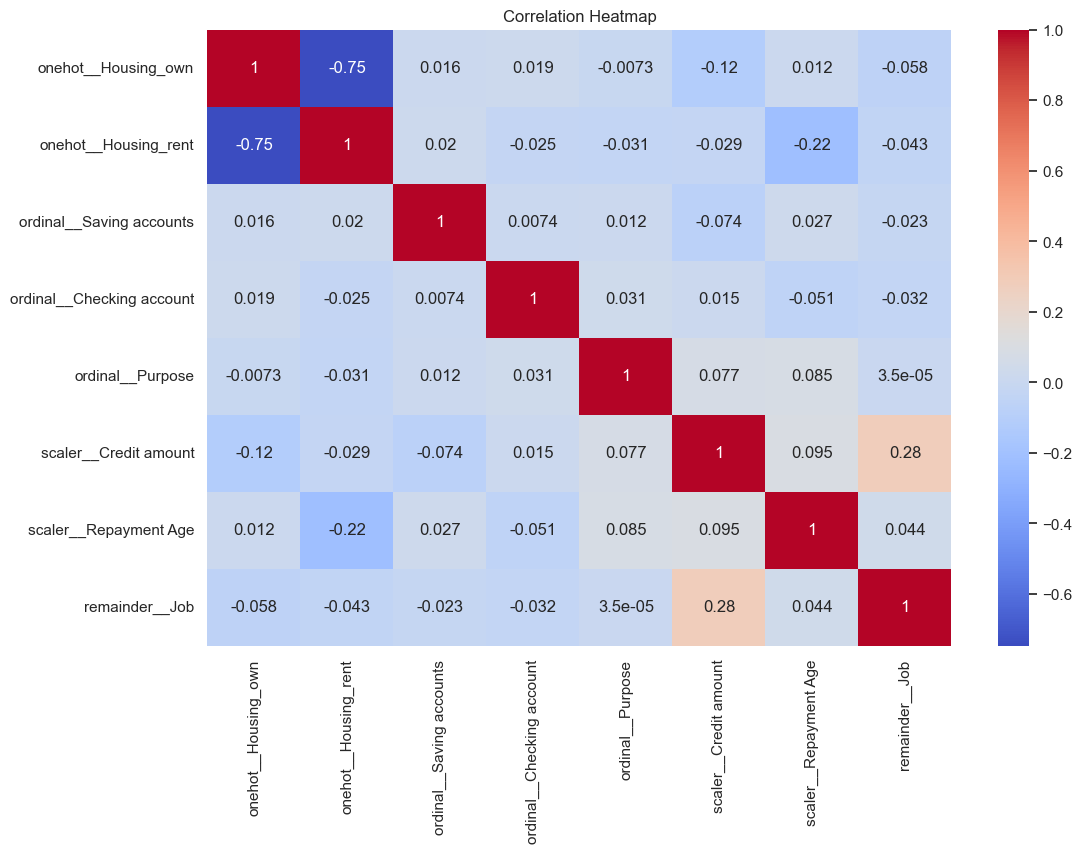

In [33]:
# Creaing Heat Map
corr = df_copy.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Adding Dependant Variable (RISK)

In [34]:
# Since RISK is not given we are adding risk variable and putting values based on some assumptions
df.head()

,Job,Housing,Saving accounts,Checking account,Credit amount,Purpose,Repayment Age
1,2,own,little,moderate,5951,radio/TV,26
2,1,own,little,little,2096,education,50
3,2,free,little,little,7882,furniture/equipment,49
4,2,free,little,little,4870,car,55
5,1,free,little,little,9055,education,38


In [35]:
df['Purpose'].unique()

array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], dtype=object)

In [36]:
# calculate median credit amount
median_credit = df['Credit amount'].median()

# Risky if No Housing & Repayment Age > 60
#       or No Job & Credit amount > median_credit
#       or little Saving Accounts & little Checking Accounts

# define the risk condition
df['Risk'] = (
    ((df['Housing'] == 'free') &
    (df['Repayment Age'] > 60)) |
    ((df['Credit amount'] > median_credit) &
    (df['Job'] == 0)) |
    ((df['Saving accounts'] == 'little') &
    (df['Checking account'] == 'little') &
    (df['Purpose'].isin(['vacation/others','car','business','radio/TV','furniture/equipment'])))

).astype(int)
df['Risk'].value_counts()

Risk
0    490
1    487
Name: count, dtype: int64

In [37]:
df.head()

,Job,Housing,Saving accounts,Checking account,Credit amount,Purpose,Repayment Age,Risk
1,2,own,little,moderate,5951,radio/TV,26,0
2,1,own,little,little,2096,education,50,0
3,2,free,little,little,7882,furniture/equipment,49,1
4,2,free,little,little,4870,car,55,1
5,1,free,little,little,9055,education,38,0


##EDA

In [38]:
df.columns.tolist()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 977 entries, 1 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Job               977 non-null    int64 
 1   Housing           977 non-null    object
 2   Saving accounts   977 non-null    object
 3   Checking account  977 non-null    object
 4   Credit amount     977 non-null    int64 
 5   Purpose           977 non-null    object
 6   Repayment Age     977 non-null    int64 
 7   Risk              977 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 68.7+ KB


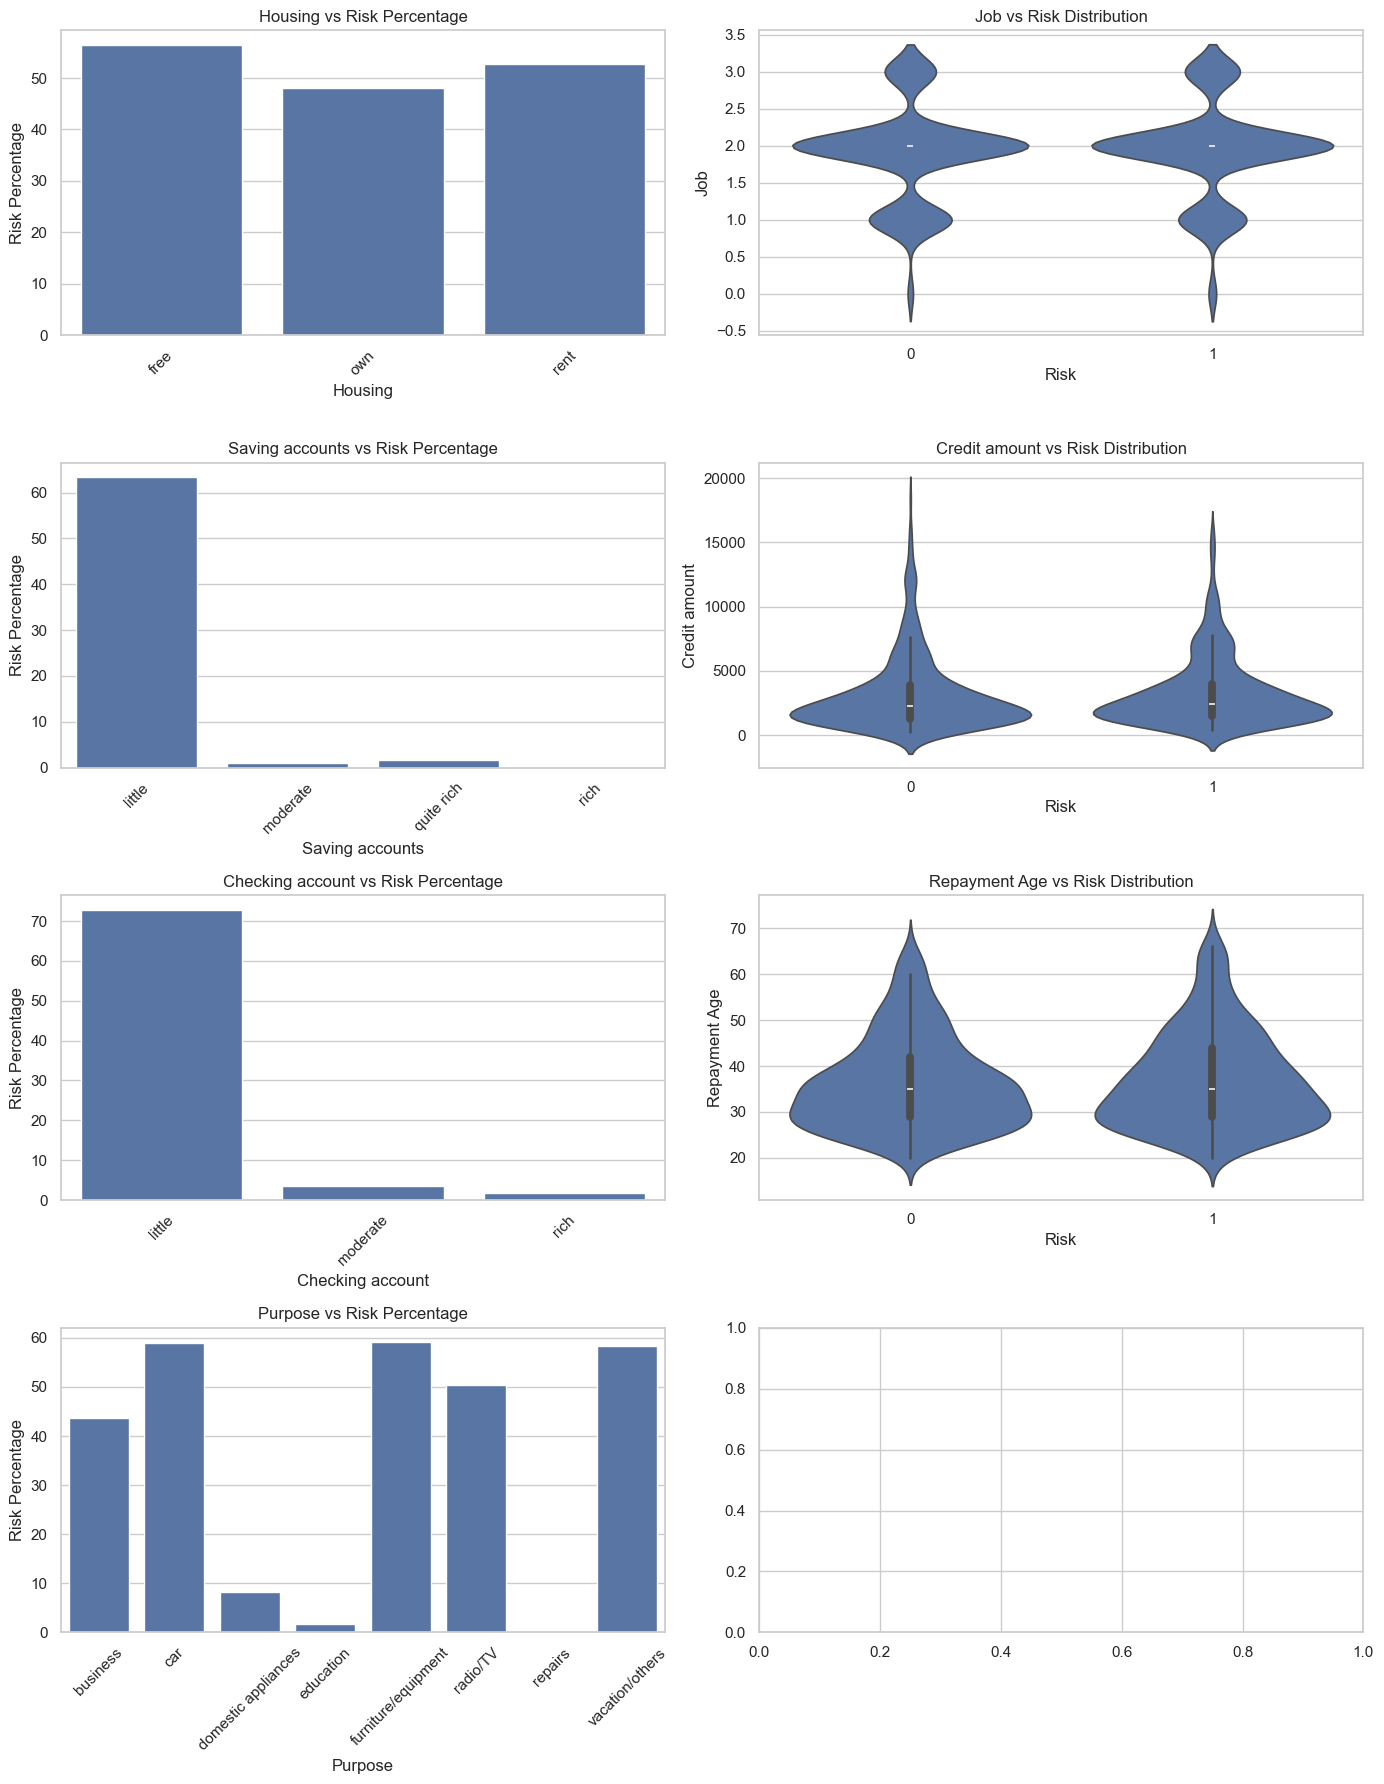

In [39]:
# Define the categorical and numerical features
categorical_features = ['Housing', 'Saving accounts', 'Checking account', 'Purpose']
numerical_features = ['Job', 'Credit amount', 'Repayment Age']

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(14, 18))  # 4 rows, 2 columns (one for each category and numerical feature)

# Plot for Categorical Features
for idx, feature in enumerate(categorical_features):
    ax = axes[idx, 0]  # Assign to first column of subplots
    risk_percentage = df.groupby(feature)['Risk'].mean() * 100  # Calculate percentage of risk
    sns.barplot(x=risk_percentage.index, y=risk_percentage.values, ax=ax)
    ax.set_title(f'{feature} vs Risk Percentage')
    ax.set_xlabel(feature)
    ax.set_ylabel('Risk Percentage')
    ax.tick_params(axis='x', rotation=45)

# Plot for Numerical Features
for idx, feature in enumerate(numerical_features):
    ax = axes[idx, 1]  # Assign to second column of subplots
    sns.violinplot(x='Risk', y=feature, data=df, ax=ax)
    ax.set_title(f'{feature} vs Risk Distribution')
    ax.set_xlabel('Risk')
    ax.set_ylabel(feature)

# Adjust layout for better spacing
plt.tight_layout()

##SPLIT DATA INTO X AND y

In [40]:
X =  df.drop('Risk', axis=1)
y = df['Risk']

##MODEL SELECTION (Logistic, Random Forest, Adaboost, Gradient Boost, XG Boost)

In [41]:
# List of classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}
# Metrics for evaluation
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [42]:
# Cross-validation evaluation
for name, clf in classifiers.items():
    # Create a pipeline with the preprocessor and the classifier
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])

    # Perform cross-validation and evaluate the model
    cv_results = cross_validate(model_pipeline, X, y, cv=5, scoring=scoring)

    # Print the average of each metric
    print(f'{name}:')
    print(f"  Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
    print(f"  Average Precision: {np.mean(cv_results['test_precision']):.4f}")
    print(f"  Average Recall: {np.mean(cv_results['test_recall']):.4f}")
    print(f"  Average F1 Score: {np.mean(cv_results['test_f1']):.4f}")
    print('-' * 50)

Logistic Regression:
  Average Accuracy: 0.9406
  Average Precision: 0.9086
  Average Recall: 0.9795
  Average F1 Score: 0.9426
--------------------------------------------------
Random Forest:
  Average Accuracy: 0.9816
  Average Precision: 0.9856
  Average Recall: 0.9775
  Average F1 Score: 0.9814
--------------------------------------------------
AdaBoost:
  Average Accuracy: 0.9673
  Average Precision: 0.9527
  Average Recall: 0.9837
  Average F1 Score: 0.9677
--------------------------------------------------
Gradient Boosting:
  Average Accuracy: 0.9898
  Average Precision: 0.9899
  Average Recall: 0.9898
  Average F1 Score: 0.9898
--------------------------------------------------
XGBoost:
  Average Accuracy: 0.9867
  Average Precision: 0.9859
  Average Recall: 0.9877
  Average F1 Score: 0.9867
--------------------------------------------------


##HYPERPARAMETER TUNING OF GRADIENT BOOSTING USING GRID SEARCH CV

In [43]:
# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Number of boosting stages
    'classifier__learning_rate': [0.01, 0.1, 0.2],  # Step size at each iteration
    'classifier__max_depth': [3, 5, 7],  # Maximum depth of the tree
    'classifier__subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
}

In [44]:
# Initialize the GradientBoostingClassifier
gb = GradientBoostingClassifier()

# Create the pipeline with preprocessor and classifier
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', gb)])

# Initialize GridSearchCV
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X, y)

# Get the best parameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50, 'classifier__subsample': 1.0}
Best Cross-Validation Score: 0.9969283097854527


In [45]:
# Access the best model from grid search
final_pipeline = grid_search.best_estimator_

# Use cross_validate to evaluate the model on multiple metrics
cv_results = cross_validate(final_pipeline, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'], n_jobs=-1)

# Print the average of each metric
print(f"Average Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Average Precision: {cv_results['test_precision'].mean():.4f}")
print(f"Average Recall: {cv_results['test_recall'].mean():.4f}")
print(f"Average F1 Score: {cv_results['test_f1'].mean():.4f}")


Average Accuracy: 0.9928
Average Precision: 0.9939
Average Recall: 0.9918
Average F1 Score: 0.9928


##EXPORT MODEL AND PIPELINE

In [46]:
# Pick one row safely
single_row = X.iloc[[0]].copy()
single_row.head()

,Job,Housing,Saving accounts,Checking account,Credit amount,Purpose,Repayment Age
1,2,own,little,moderate,5951,radio/TV,26


In [47]:
# Now predict
prediction = final_pipeline.predict(single_row)
print('Prediction ',prediction, ' Actual ',y.iloc[[0]])

Prediction  [0]  Actual  1    0
Name: Risk, dtype: int64


In [48]:
print ('Input should be in this format : ',X.columns.tolist())

Input should be in this format :  ['Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Purpose', 'Repayment Age']


In [49]:
with open('model_pipeline.pkl', 'wb') as f:
    pickle.dump(final_pipeline, f)